# Desafío - Máquinas de Soporte Vectorial (Sebastián Rebolledo)

### Ejercicio 1: Preparar el ambiente de trabajo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
plt.rcParams['figure.figsize'] = (10, 6) 

In [3]:
df = pd.read_csv('breast_cancer.csv').drop(['Unnamed: 32', 'id'], axis=1)

In [4]:
df.sample()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
224,B,13.27,17.02,84.55,546.4,0.08445,0.04994,0.03554,0.02456,0.1496,...,15.14,23.6,98.84,708.8,0.1276,0.1311,0.1786,0.09678,0.2506,0.07623


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

#### Se recodificará el vector objetivo diagnosis con un 1 para B(Benigno) y un 0 para M(Maligno)

In [7]:
df.diagnosis = np.where(df.diagnosis == 'B', 1, 0)

In [8]:
df.diagnosis.value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

### Ejercicio 2: Visualizando la distribución de los atributos

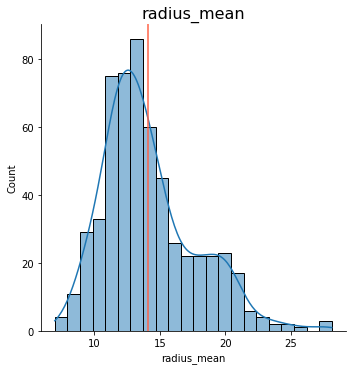

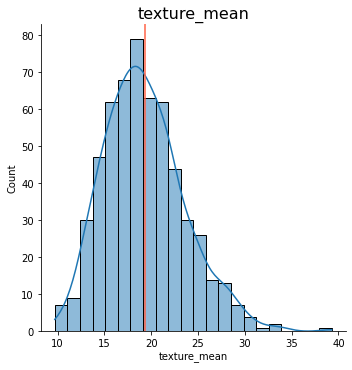

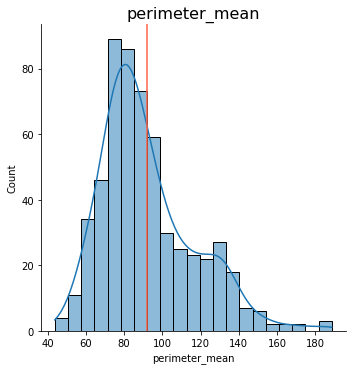

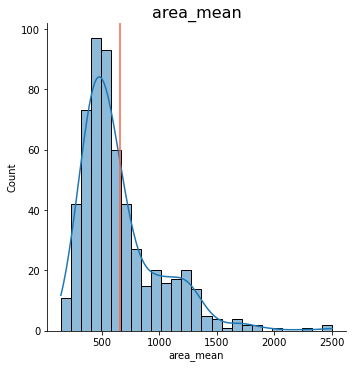

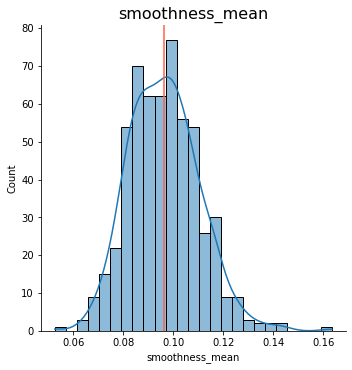

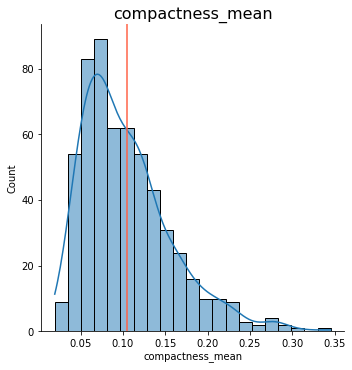

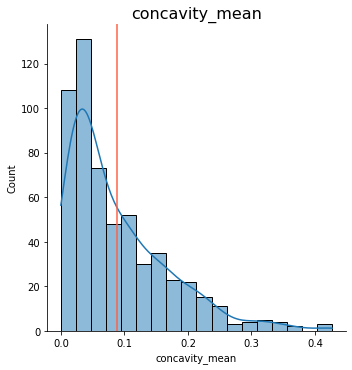

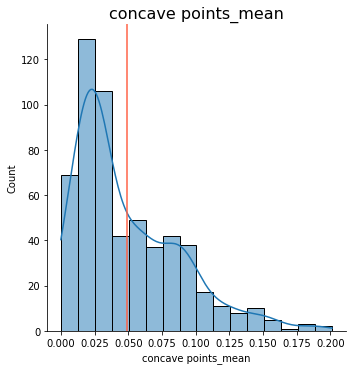

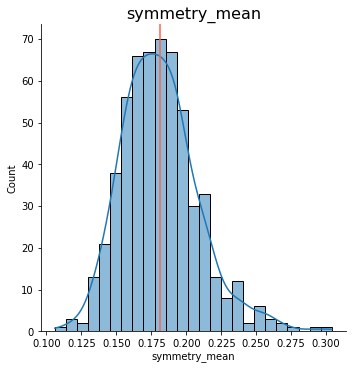

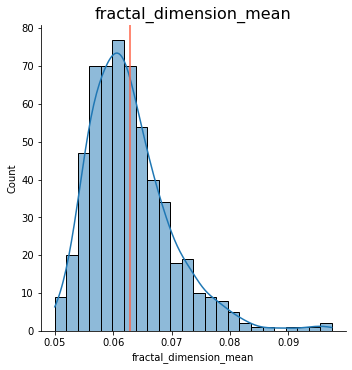

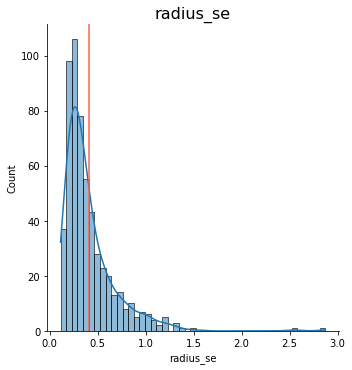

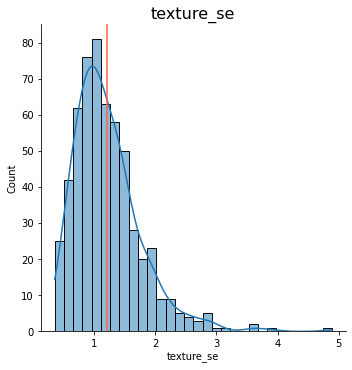

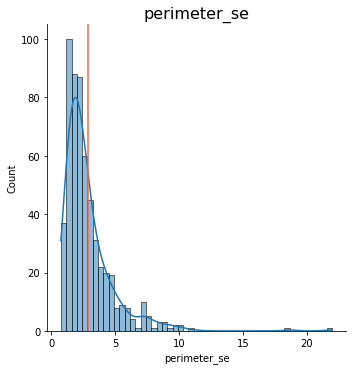

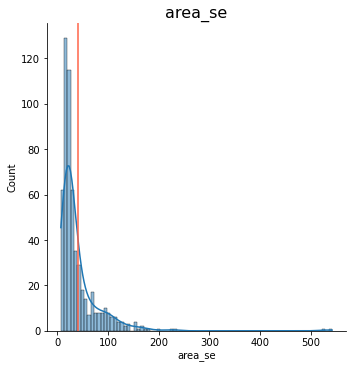

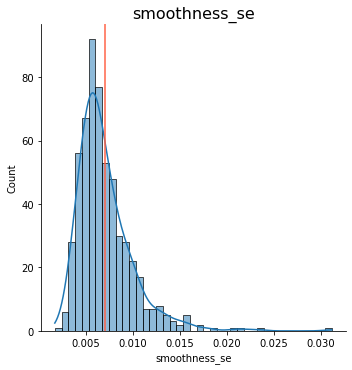

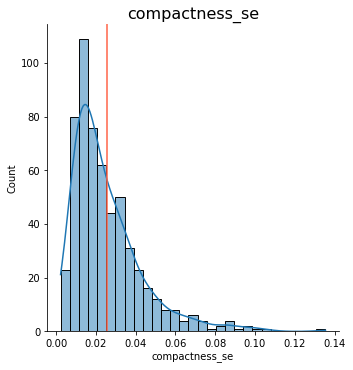

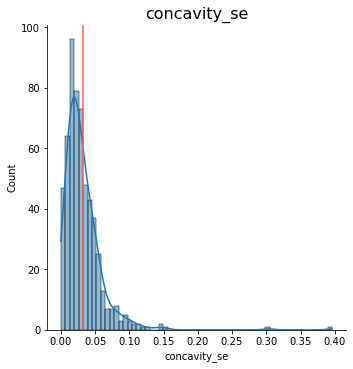

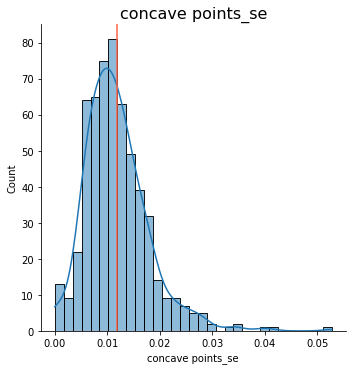

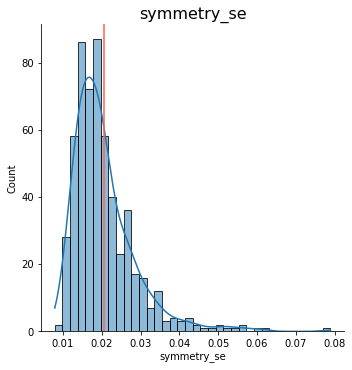

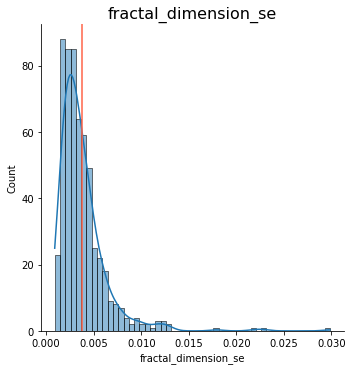

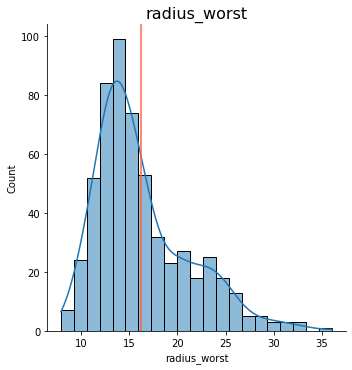

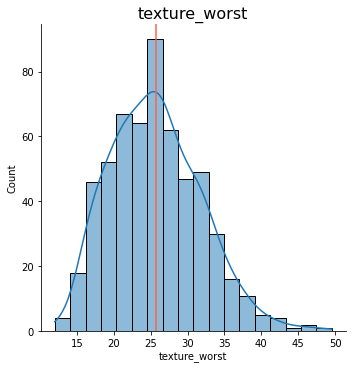

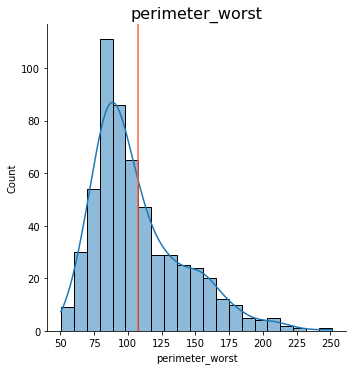

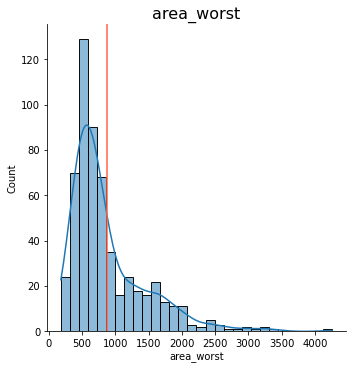

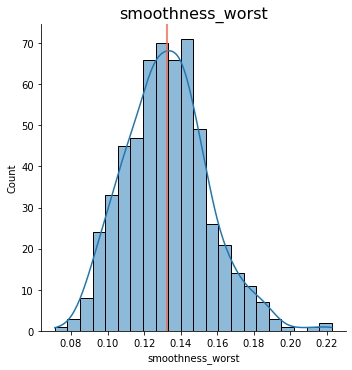

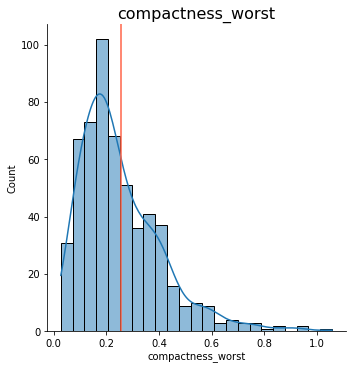

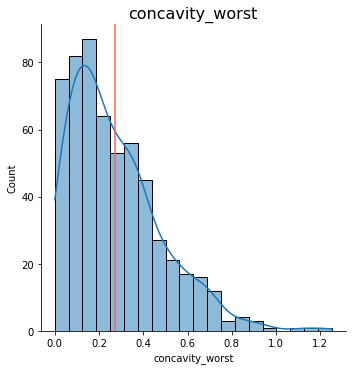

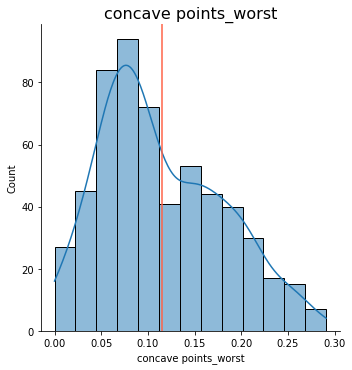

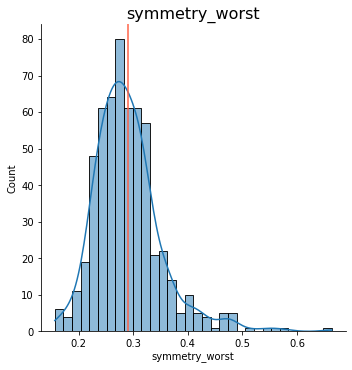

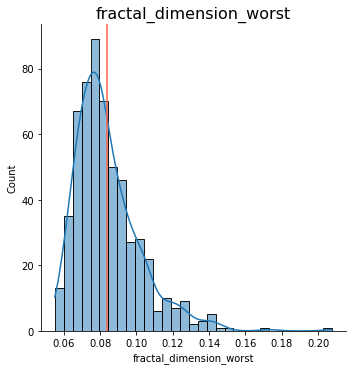

In [9]:
for cols in df.drop('diagnosis', axis=1).columns:
    sns.displot(df[cols], kde=True)
    plt.axvline(np.mean(df[cols]), color = 'tomato')
    plt.title(cols, fontdict={'fontsize':16})
    plt.show()

#### Los atributos que tienen una distribucion similar son:
- area_mean
- concavity_mean
- concave point_mean
- radius_se
- texture_se
- perimeter_se
- area_se
- compactness_se
- concavity_se
- fractal_dimension_se
- compactness_worst
- concavity_worst

/home/seba/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


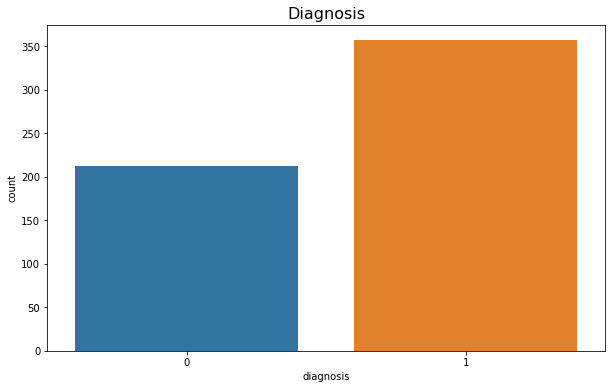

In [10]:
sns.countplot(df['diagnosis'])
plt.title('Diagnosis', fontdict={'fontsize':16})
plt.show()

### Ejercicio 3: Estimando el porcentaje de overlap en los atributos

In [11]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
    # get histogram
        tmp, _ = np.histogram(
    # for a specific attribute
            df[df[target] == unique_value][attribute],
    # define percentage
            bins=perc,
    # limit empirical range for comparison
            range=[empirical_lower_bound, empirical_upper_bound]
        )
    # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [12]:
comunalidad, columna = [],[]
df_comunalidad = pd.DataFrame()
for cols in df.drop('diagnosis', axis=1):
    operacion = histogram_overlap(df, cols,'diagnosis')
    comunalidad.append(operacion)
    columna.append(cols)
df_comunalidad['atributo'] = columna
df_comunalidad['comunalidad']= comunalidad

In [13]:
df_comunalidad = df_comunalidad.set_index('atributo')

In [14]:
df_comunalidad.sort_values(by=['comunalidad'], ascending=False)

,comunalidad
atributo,
fractal_dimension_se,1.000000
smoothness_se,0.995283
fractal_dimension_mean,0.990566
symmetry_se,0.957547
texture_se,0.924528
compactness_se,0.882075
smoothness_mean,0.877358
symmetry_mean,0.858491
concave points_se,0.853774


### Ejercicio 4: Selección del modelo por GridSearchCV

In [15]:
X= df.drop('diagnosis', axis=1)
y= df['diagnosis']

In [16]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X,y, test_size =.3 , random_state = 212)

In [17]:
sc =StandardScaler().fit(X_train_pre)

In [18]:
X_train = pd.DataFrame(sc.transform(X_train_pre), columns=X_train_pre.columns)

In [19]:
X_test = pd.DataFrame(sc.transform(X_test_pre), columns=X_test_pre.columns)

In [20]:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [21]:
svc_grid = GridSearchCV(SVC(), param_grid=params, cv=10, n_jobs=-1).fit(X_train, y_train)

In [22]:
svc_grid.best_params_

{'C': 100, 'gamma': 0.001}

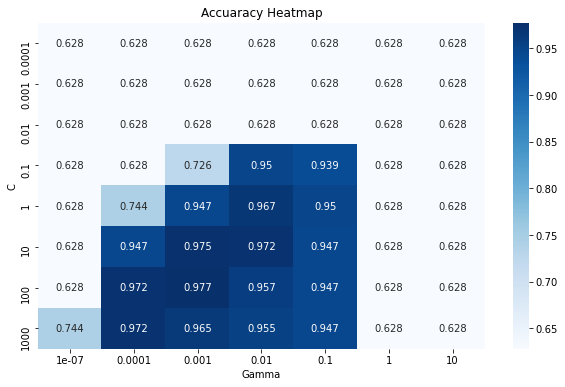

In [23]:
sns.heatmap(svc_grid.cv_results_['mean_test_score'].reshape(8,7), annot=True, xticklabels=params['gamma'],
            yticklabels=params['C'], cmap='Blues', fmt='.3')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuaracy Heatmap')
plt.show()

#### Se observa en el grafico que la mejor combinacion de parametros es C = 100 y gamma = 0,001.

### Ejercicio 5: Validación del modelo en el hold-out sample

In [24]:
y_hat = svc_grid.best_estimator_.predict(X_test)

In [25]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.99      0.98      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



#### En base a los resultados, podemos decir, que el modelo es muy bueno, ya que cada vez que el modelo dijo que un ejemplo pertenece a la clase 1(Benigno), el 99% de las veces realmente lo era. Y cada vez que dijo que un ejemplo pertenecia a la clase 0(Maligno),  el 97% de las veces realmente lo era.

#### Los valores de recall indican la proporcion de elementos de una clase en especifico que modelo logro identificar correctamente. Esto quiere decir que de todos los ejemplos que habian realmente de la clase 1(Benigno), el algoritmo encontro el 98% de esos ejemplo. Lo mismo ocurre para la clase 0(Maligno)